# Generation of synthetic EKG signals using GANs and Neurokit library

## 0. Generating the database with Neurokit2

In [3]:
!pip install -U pywavelets neurokit2 

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   --------- ------------------------------ 1.0/4.2 MB 6.7 MB/s eta 0:00:01
   ----------------- ---------------------- 1.8/4.2 MB 4.5 MB/s eta 0:00:01
   ----------------- ---------------------- 1.8/4.2 MB 4.5 MB/s eta 0:00:01
   ------------------- -------------------- 2.1/4.2 MB 3.1 MB/s eta 0:00:01
   ------------------- -------------------- 2.1/4.2 MB 3.1 MB/s eta 0:00:01
   ------------------- -------------------- 2.1/4.2 MB 3.1 MB/s eta 0:00:01
   ------------------------ --------------- 2.6/4.2 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 2.4 MB/s  0:00:01
   ---------------------------------------- 0.0/708.4 kB ? eta -:--:--
   -------------- ------------------------- 262.1/708.4 kB ? eta -:--:--
   ---------------------------- --------- 524.3/708.4 kB 971.4 kB/s eta 0:00:01
   ------------------------------

In [4]:
import pandas as pd
import os
import random
import numpy as np
import warnings
import neurokit2 as nk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

warnings.filterwarnings("ignore")

In [5]:
devices = tf.config.list_physical_devices('GPU')
print(devices)

[]


In [8]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Dependencias
print("TF version:", tf.__version__)
tf.random.set_seed(SEED)

sig = nk.ecg_simulate(
        duration=10,
        sampling_rate=1000,
        heart_rate=70,
        noise=0.01,
        method="ecgsyn"
    )

np.asarray(sig, dtype=np.float32).reshape(-1, 1)

TF version: 2.20.0


array([[1.0660845 ],
       [1.0618839 ],
       [1.0523672 ],
       ...,
       [0.00290521],
       [0.00331089],
       [0.00357093]], shape=(10000, 1), dtype=float32)

In [ ]:
# Semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Dependencias
print("TF version:", tf.__version__)
tf.random.set_seed(SEED)

# --------------------------------------------------------
# 1) Generación de dataset sintético con neurokit2
# --------------------------------------------------------
def simulate_ecg_sample(duration_s=8, fs=1000, hr_bpm=70, noise=0.01):
    # ECG sintético; método ecgsyn de neurokit2
    sig = nk.ecg_simulate(
        duration=duration_s,
        sampling_rate=fs,
        heart_rate=hr_bpm,
        noise=noise,
        method="ecgsyn"
    )
    # Aseguramos forma (T, 1) y float32
    x = np.asarray(sig, dtype=np.float32).reshape(-1, 1)
    # Normalización por muestra (z-score)
    m = x.mean()
    s = x.std() + 1e-8
    x = (x - m) / s
    return x

def make_dataset(n_per_class=100, duration_s=8, fs=200, seed=SEED):
    rng = np.random.default_rng(seed)
    classes = {
        "normal": {"hr_range": (60, 80), "noise": (0.005, 0.02)},
        "bradicardia": {"hr_range": (35, 50), "noise": (0.005, 0.02)},
        "taquicardia": {"hr_range": (100, 130), "noise": (0.005, 0.02)},
    }
    X, y, names = [], [], list(classes.keys())

    for label, cfg in enumerate(names):
        hr_lo, hr_hi = classes[cfg]["hr_range"]
        nz_lo, nz_hi = classes[cfg]["noise"]
        for _ in range(n_per_class):
            hr = float(rng.uniform(hr_lo, hr_hi))
            nz = float(rng.uniform(nz_lo, nz_hi))
            x = simulate_ecg_sample(duration_s=duration_s, fs=fs, hr_bpm=hr, noise=nz)
            X.append(x)
            y.append(label)

    # Aseguramos misma longitud (por si hubiese ligeras variaciones)
    T = int(duration_s * fs)
    X = [xi[:T] if len(xi) >= T else np.pad(xi, ((0, T-len(xi)), (0, 0))) for xi in X]
    X = np.stack(X, axis=0).astype(np.float32)   # (N, T, 1)
    y = np.array(y, dtype=np.int64)
    return X, y, names

# Parámetros del dataset
N_PER_CLASS = 100    # Ajusta si quieres más datos
DURATION_S   = 8
FS           = 200

X, y, class_names = make_dataset(
    n_per_class=N_PER_CLASS,
    duration_s=DURATION_S,
    fs=FS,
    seed=SEED
)
N, T, C = X.shape
num_classes = len(class_names)
print(f"Dataset: {N} muestras, secuencia {T}x{C}, clases: {class_names}")



TF version: 2.20.0
Dataset: 300 muestras, secuencia 1600x1, clases: ['normal', 'bradicardia', 'taquicardia']
Split -> train: 210, val: 45, test: 45


In [ ]:
80*150*3.5 # TEchnical research.

42000.0

In [ ]:
# Train/Val/Test split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED
)
print(f"Split -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


In [8]:
X_train.shape, y_train.shape

((210, 1600, 1), (210,))

In [12]:
import matplotlib.pyplot as plt

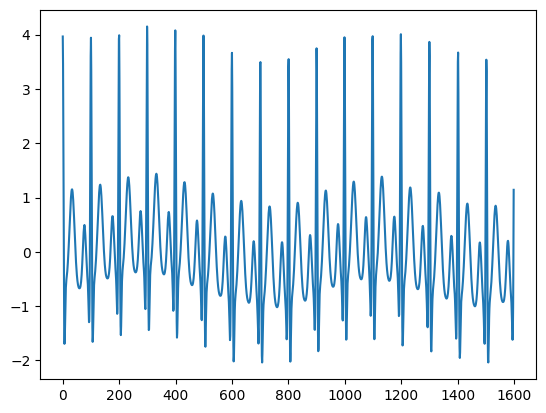

In [13]:
plt.plot(X_train[0][:,0])

## 1. Understanding of the bussiness

## 2. Understanding the data

## 3. Preparing the model

In [14]:
# --------------------------------------------------------
# 2) Modelo LSTM (Keras)
# --------------------------------------------------------
def build_lstm_model(seq_len, n_channels, n_classes):
    inputs = keras.Input(shape=(seq_len, n_channels))
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_lstm_model(seq_len=T, n_channels=C, n_classes=num_classes)
model.summary()

# Callbacks
early = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Entrenamiento
EPOCHS = 20
BATCH  = 32
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=1,
    callbacks=[early]
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1600, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1600, 128)      │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,187 (301.51 KB)

 Trainable params: 77,187 (301.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3810 - loss: 1.0852 - val_accuracy: 0.3556 - val_loss: 1.0611
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3905 - loss: 1.0489 - val_accuracy: 0.3333 - val_loss: 1.0152
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4619 - loss: 0.9852 - val_accuracy: 0.6000 - val_loss: 0.9102
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7048 - loss: 0.8536 - val_accuracy: 0.7778 - val_loss: 0.6817
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8714 - loss: 0.5921 - val_accuracy: 0.9333 - val_loss: 0.3912
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9571 - loss: 0.3207 - val_accuracy: 1.0000 - val_loss: 0.1831
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9571 - loss: 0.1908 - val_accuracy: 0.9556 - val_loss: 0.1034
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9905 - loss: 0.0831 - val_accuracy: 1.0000 - val_loss: 0.0265
Epoch 9/

In [15]:

# --------------------------------------------------------
# 3) Métricas en Test
# --------------------------------------------------------
probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted", zero_division=0
)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Métricas finales (Test) ===")
print(f"Accuracy:      {acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f} | Recall (macro): {rec_macro:.4f} | F1 (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec_w:.4f} | Recall (weighted): {rec_w:.4f} | F1 (weighted): {f1_w:.4f}")

print("\n=== Classification report (por clase) ===")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))



=== Métricas finales (Test) ===
Accuracy:      1.0000
Precision (macro): 1.0000 | Recall (macro): 1.0000 | F1 (macro): 1.0000
Precision (weighted): 1.0000 | Recall (weighted): 1.0000 | F1 (weighted): 1.0000

=== Classification report (por clase) ===
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        15
 bradicardia       1.00      1.00      1.00        15
 taquicardia       1.00      1.00      1.00        15

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [16]:
print("=== Matriz de confusión ===")
print(pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                      columns=[f"pred_{c}" for c in class_names]))


=== Matriz de confusión ===
                  pred_normal  pred_bradicardia  pred_taquicardia
true_normal                15                 0                 0
true_bradicardia            0                15                 0
true_taquicardia            0                 0                15
